In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from math import sqrt

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load in ames home price train and test data
ames_train = pd.read_csv("ames_train.csv")
ames_test = pd.read_csv("ames_test.csv")
#ames_train.info()

In [3]:
# create variables for train and test data separately, x for predictors, y for response

y_train = ames_train.price
x_predictors_train = ames_train[["area", "Lot.Area", "Fireplaces", "TotalSq", "Garage.Cars", "Lot.Frontage", "Overall.Qual", "Overall.Cond", "Year.Built", "Mas.Vnr.Area", "BsmtFin.SF.1", "X1st.Flr.SF", "X2nd.Flr.SF"]].fillna(value=0)

y_test = ames_test.price
x_predictors_test = ames_test[["area", "Lot.Area", "Fireplaces", "TotalSq", "Garage.Cars", "Lot.Frontage", "Overall.Qual", "Overall.Cond", "Year.Built", "Mas.Vnr.Area", "BsmtFin.SF.1", "X1st.Flr.SF", "X2nd.Flr.SF"]].fillna(value=0)

### Alternative Algorithm: PCA

In [4]:
# scale x train data
x_scaled_train = PCA().fit_transform(scale(x_predictors_train))
n = len(x_scaled_train)

# perform cross validation (10 k-fold)
cross_val_k_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)
root_mean_sq_error_vals = []

# calculate rmse values for intercept (no predictors/components)
mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), np.ones((n,1)), y_train.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
root_mean_sq_error_vals.append(sqrt(mean_sq_error))

# calculate rmse values for varying numbers of predictors/components
for i in range(1, len(x_predictors_train.columns)):
    mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), x_scaled_train[:,:i], y_train.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
    root_mean_sq_error_vals.append(sqrt(mean_sq_error))

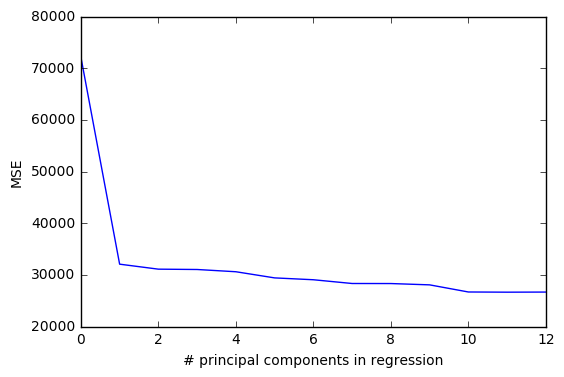

In [5]:
plt.plot(root_mean_sq_error_vals)
plt.xlabel("# principal components in regression")
plt.ylabel("MSE")

In [8]:
# run regression using the number of principle components with smallest mse
pca_regression = lin_reg().fit(x_scaled_train[:,:10], y_train)

# use regression above to predict on test data
x_scaled_test = PCA().fit_transform(scale(x_predictors_test))[:,:10]
y_test_predictions = pca_regression.predict(x_scaled_test)
rmse_test = sqrt(mean_squared_error(y_test, y_test_predictions))
print("The root mean squared error for the model using PCA is: %d " %rmse_test)

The root mean squared error for the model using PCA is: 28179 


### Description of algorithm

PLS is a regression method used to overcome limitations discussed above for normal linear regressions (e.g., many collinear predictors, more predictors than samples, etc.) by mapping observed sets of observed variables to response variables by means of latent variables. Essentially the model assumes that the data is generated by an underlying model directed by a smaller number of latent variables in the data. 

First, two sets of latent variables are extracted from the data: $T$ (or x-scores) from the predictors, and $U$ (or y-scores) from the response variable. These latent vectors are determined through maximizing the covariance between different sets of variables. 

For the classic linear regression, we try to solve the equation, $ Y = XB + {\epsilon} $, where the ordinary least squares estimate for ${\beta}$ is identified as ${(X^T X)}^{-1} X^TY$. This estimate is obtained by minimizing the sum of squared residuals. However, models that have predictors with high collinearity or more predictors than observations can result in singularity of the matrix ${(X^T X)}$. As an alternative and way to fix this issue, we implement the PLS algorithm throught the following steps:

1) Start with vector $u$. If there is only one response variable, then $ u = y $, otherwise it is one of the columns of $Y$.

2) Calculate the weights for the predictors ($X$) :
$$ w = \frac{X^Tu}{u^Tu} $$

3) Determine $t$ ($X$ scores):
$$ t = Xw $$

4) Now perform similar calculations for $Y$. Calculate the weights for the response variable:
$$ c = \frac{X^Tt}{t^Tt} $$

5) Determine $u$ ($Y$ scores):
$$ u = \frac{Yc}{c^Tc} $$

6) If there is more than one response variable, then we test to determine whether the $t$ values have converged. If the change in $t$ from one iteration to the next, $ \frac{||t_{old} - t_{new}}{||t_{new}||} $, is not smaller than a threshold value, then we iterate through steps 2-5 until convergence is reached.

7) Deflate variables for next iteration.
$$ p = \frac{X^Tt}{t^Tt} $$
$$ X = X - tp^T $$
$$ Y = Y - tc^T $$

8) Iterate through components until they are not found to be predictive of $Y$.